In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
#from astroquery.mast import Observations
import lightkurve as lk
import celerite
from celerite import terms
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table
from lightkurve import search_lightcurvefile
from lightkurve import search_targetpixelfile

In [4]:
target = '9726699'
gj1243_collection = search_lightcurvefile(target,cadence='short').download_all()

gj1243lc = gj1243_collection[0].PDCSAP_FLUX.remove_nans()

#stitching together the full light curve
for q in range(1,len(gj1243_collection)):
    try:
        gj1243lc = gj1243lc.append(gj1243_collection[q].PDCSAP_FLUX).remove_nans()
    except:
            print(q)

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

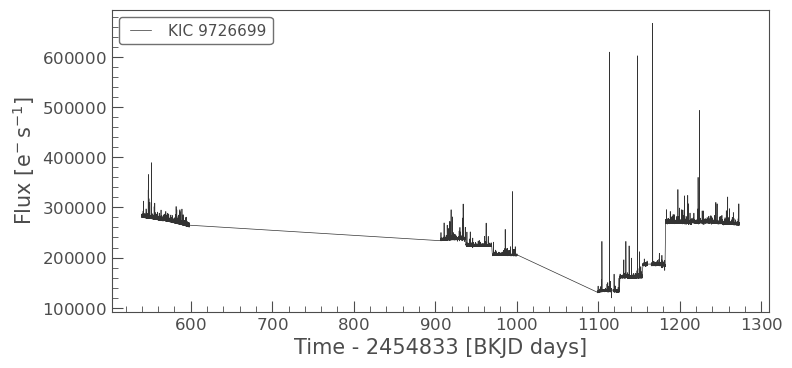

In [5]:
gj1243lc.plot()

Importing in a few flare stars from short cadence TESS data

In [6]:
from astroquery.mast import Observations
from astroquery.mast import Catalogs
from astropy.io import fits
from astropy.timeseries import TimeSeries
from astropy.utils.data import get_pkg_data_filename

In [26]:
fs1 = get_pkg_data_filename('/Users/lupitatovar/local_flares/TESS_Flare_Stars/tess2020294194027-s0031-0000000197829751-0198-a_fast-lc.fits')
fs2 = get_pkg_data_filename('/Users/lupitatovar/local_flares/TESS_Flare_Stars/tess2020_match_2min_294194027-s0031-0000000197829751-0198-s_lc.fits')
fs3 = get_pkg_data_filename('/Users/lupitatovar/local_flares/TESS_Flare_Stars/tess2020351194500-s0033-0000000272232401-0203-a_fast-lc.fits')

In [27]:
#fs1
fs2

'/Users/lupitatovar/local_flares/TESS_Flare_Stars/tess2020_match_2min_294194027-s0031-0000000197829751-0198-s_lc.fits'

In [28]:
lc1 = TimeSeries.read(fs1,format='tess.fits')
lc2 = TimeSeries.read(fs2,format='tess.fits')
lc3 = TimeSeries.read(fs3,format='tess.fits')

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 6045 rows with NaN times
  warnings.warn('Ignoring {} rows with NaN times'.format(np.sum(nans)))
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1009 rows with NaN times
  warnings.warn('Ignoring {} rows with NaN times'.format(np.sum(nans)))
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 6750 rows with NaN times
  warnings.warn('Ignoring {} rows with NaN times'.format(np.sum(nans)))


In [29]:
#lc1['time', 'sap_flux']
lc1.time.mjd

array([59144.00942617, 59144.00965765, 59144.00988913, ...,
       59169.44652103, 59169.44675251, 59169.44698399])

Text(0, 0.5, 'SAP Flux (e-/s)')

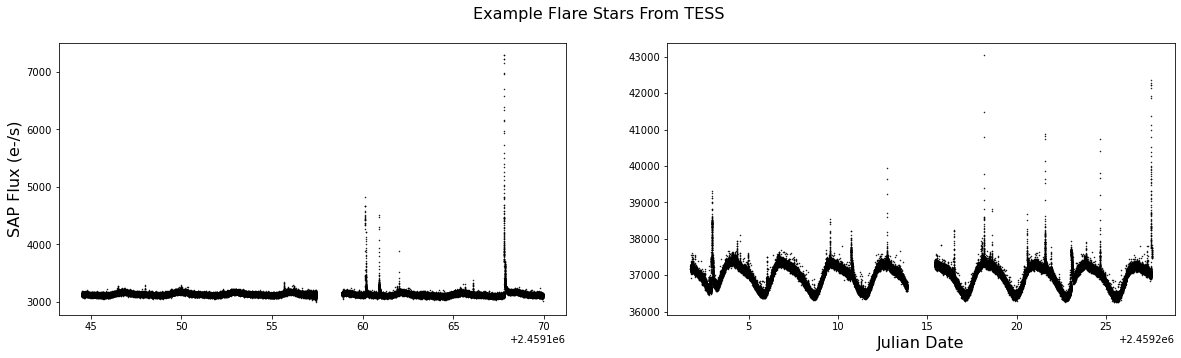

In [30]:
fig, axs = plt.subplots(1,2, figsize=(20, 5), facecolor='w', edgecolor='k')
fig.suptitle('Example Flare Stars From TESS',fontsize='16')

axs[0].plot(lc1.time.jd, lc1['sap_flux'], 'k.', markersize=1)
#axs[1].plot(lc2.time.jd, lc2['sap_flux'], 'k.', markersize=1)
axs[1].plot(lc3.time.jd, lc3['sap_flux'], 'k.', markersize=1)


axs[1].set_xlabel('Julian Date',fontsize='16')
axs[0].set_ylabel('SAP Flux (e-/s)',fontsize='16')

Text(0, 0.5, 'SAP Flux (e-/s)')

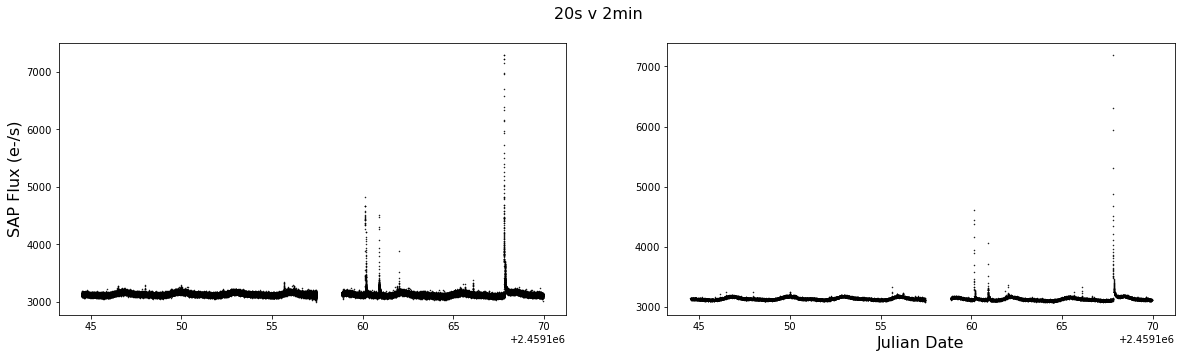

In [31]:
fig, axs = plt.subplots(1,2, figsize=(20, 5), facecolor='w', edgecolor='k')
fig.suptitle('20s v 2min',fontsize='16')

axs[0].plot(lc1.time.jd, lc1['sap_flux'], 'k.', markersize=1)
axs[1].plot(lc2.time.jd, lc2['sap_flux'], 'k.', markersize=1)


axs[1].set_xlabel('Julian Date',fontsize='16')
axs[0].set_ylabel('SAP Flux (e-/s)',fontsize='16')

In [365]:
from scipy import special
def flare_model(t,tpeak, fwhm, ampl):

    t_new = (t-tpeak)/fwhm +2


    #Values were fit & calculated using MCMC 256 walkers and 10000 steps

    A,B,C,D1,D2,f1 = [2.93019203, 1.78279154, 0.3113989, 0.21181818, 1.63976688, 0.13602386]
    z1 = ((2*B + (C**2 *D1))/(2*C))
    z2 = ((2*B + C**2 *D2)/(2*C))
    f2 = 1-f1
    flare = (1/2) * np.sqrt(np.pi) * A * C * ((f1 * np.exp((D1*(B-t_new)) + ((C**2 * D1**2)/4))*(special.erf(z1) - special.erf(z1 - (t_new/C))))
                                             + (f2 * np.exp((D2*(B-t_new)) + ((C**2 * D2**2)/4))*(special.erf(z2) - special.erf(z2 - (t_new/C)))))
    return flare * ampl

In [33]:
from scipy.stats import binned_statistic

def aflare1(t, tpeak, fwhm, ampl, upsample=False, uptime=10):
    '''
    The Analytic Flare Model evaluated for a single-peak (classical).
    Reference Davenport et al. (2014) http://arxiv.org/abs/1411.3723
    Use this function for fitting classical flares with most curve_fit
    tools.
    Note: this model assumes the flux before the flare is zero centered
    Parameters
    ----------
    t : 1-d array
        The time array to evaluate the flare over
    tpeak : float
        The time of the flare peak
    fwhm : float
        The "Full Width at Half Maximum", timescale of the flare
    ampl : float
        The amplitude of the flare
    upsample : bool
        If True up-sample the model flare to ensure more precise energies.
    uptime : float
        How many times to up-sample the data (Default is 10)
    Returns
    -------
    flare : 1-d array
        The flux of the flare model evaluated at each time
    '''
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]

    if upsample:
        dt = np.nanmedian(np.diff(t))
        timeup = np.linspace(min(t)-dt, max(t)+dt, t.size * uptime)

        flareup = np.piecewise(timeup, [(timeup<= tpeak) * (timeup-tpeak)/fwhm > -1.,
                                        (timeup > tpeak)],
                                    [lambda x: (_fr[0]+                       # 0th order
                                                _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                                _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                                _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                                _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                                     lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                                _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                                    ) * np.abs(ampl) # amplitude

        # and now downsample back to the original time...
        ## this way might be better, but makes assumption of uniform time bins
        # flare = np.nanmean(flareup.reshape(-1, uptime), axis=1)

        ## This way does linear interp. back to any input time grid
        # flare = np.interp(t, timeup, flareup)

        ## this was uses "binned statistic"
        downbins = np.concatenate((t-dt/2.,[max(t)+dt/2.]))
        flare,_,_ = binned_statistic(timeup, flareup, statistic='mean',
                                 bins=downbins)

    else:
        flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
                                 (t > tpeak)],
                                [lambda x: (_fr[0]+                       # 0th order
                                            _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                            _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                            _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                            _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                                 lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                            _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                                ) * np.abs(ampl) # amplitude

    return flare

In [43]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
#rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True

(2459160.87, 2459160.95)

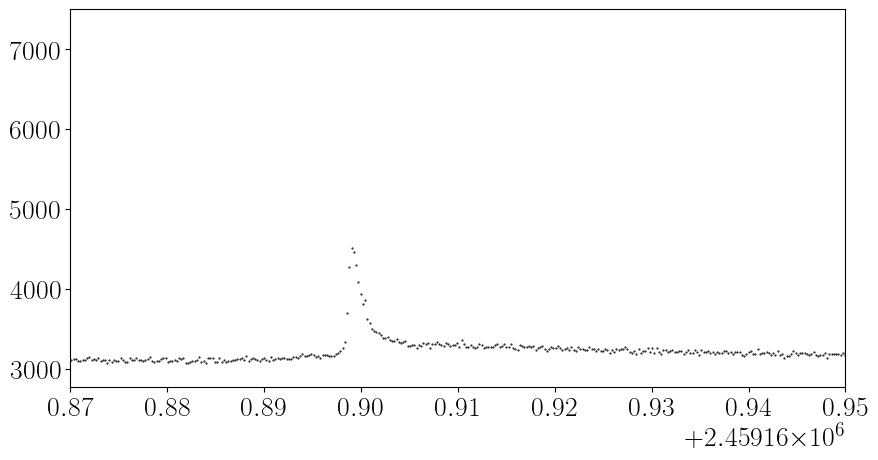

In [80]:
plt.figure(figsize=(10,5))
plt.plot(lc1.time.jd, lc1['sap_flux'], 'k.', markersize=1)
#plt.xlim(2.65e6,2.70e6)
plt.xlim(60.87+2.4591e6,60.95+2.4591e6)

Text(0, 0.5, 'Flux')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


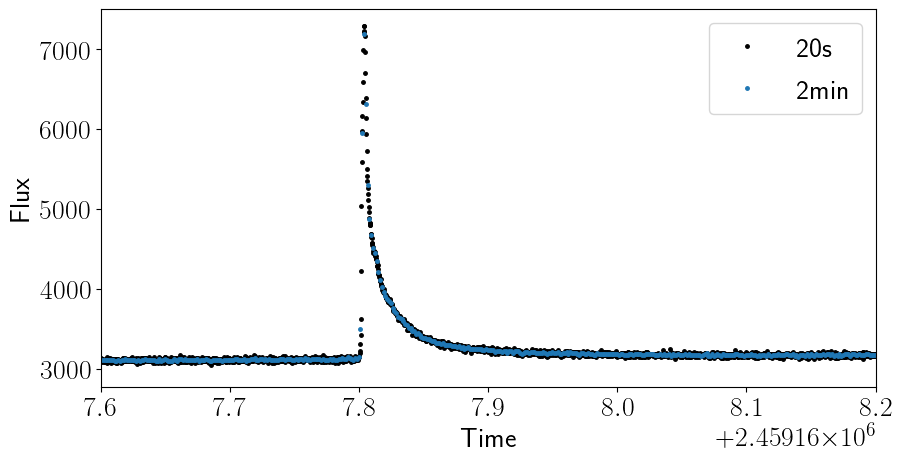

In [45]:
plt.figure(figsize=(10,5))
plt.plot(lc1.time.jd, lc1['sap_flux'], 'k.', markersize=5,label='20s')
plt.plot(lc2.time.jd, lc2['sap_flux'], 'k.', markersize=5,color='C0',label='2min')
plt.xlim(67.6+2.4591e6,68.2+2.4591e6)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Flux')

In [46]:
lc1median = (lc1['sap_flux']/np.nanmedian(lc1['sap_flux']))-1
lc2median = (lc2['sap_flux']/np.nanmedian(lc2['sap_flux']))-1

Text(0, 0.5, 'Relative Flux')

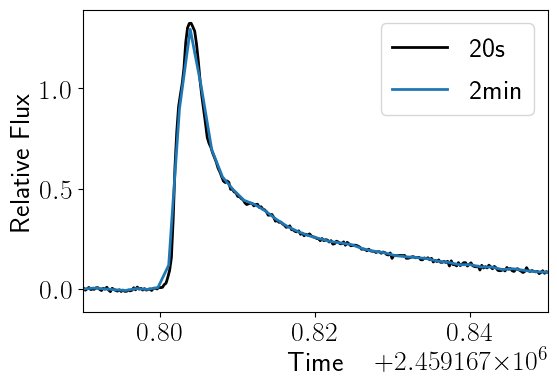

In [56]:
plt.plot(lc1.time.jd,lc1median,color='black', label='20s',lw=2)
plt.plot(lc2.time.jd,lc2median,color='C0',label='2min',lw=2)
plt.xlim(67.79+2.4591e6,67.85+2.4591e6)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Relative Flux')

In [57]:
mask = ~(np.isnan(lc1.time.jd) | np.isnan(lc1median))
print(mask)

[False False False ...  True  True  True]


In [59]:
xmin = 67.6+2.4591e6
xmax = 68.2+2.4591e6
x_mask = np.where((lc1.time.jd[mask] > xmin) & (lc1.time.jd[mask] < xmax))[0]
print(len(x_mask))
print(len(lc1.time.jd))

2592
103848


In [60]:
print(len(lc1.time.jd[mask][x_mask]))
print(len(lc1median[mask][x_mask]))

2592
2592


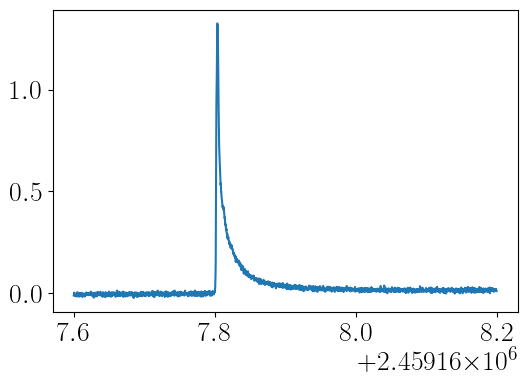

In [61]:
plt.plot(lc1.time.jd[mask][x_mask],lc1median[mask][x_mask])

In [ ]:
np.polyfit(lc1.time.jd[mask][x_mask],lc1median[mask][x_mask], 2)

Fitting new analytical model

In [82]:
from scipy.optimize import curve_fit
xfit = lc1.time.jd[mask][x_mask] - 2.45916781e+06 # approx t_peak
yfit = lc1median[mask][x_mask]

In [83]:
print(len(xfit))
print(len(yfit))

2592
2592


In [84]:
#init_vals= [2.45916777e+06, 1.72434046e-02, 6.99969939e-01]
#init_vals =[2.45916714e+06, 0.4,1.4]
#bounds=((xmin,2e-02,6e-01),(xmax,1,1.5))

#init_vals= [2.45916779e+06, .65e-02, 1.389] #These look a lot better!
init_vals =[-0.005, .7e-02, 1.38] #Jim's vals
#init_vals=[2.45916779e+06, 7.00000000e-03, 1.39000000e+00]
popt, pcov = curve_fit(flare_model, xfit,yfit, p0=init_vals,maxfev=100000)

(-0.05, 0.1)

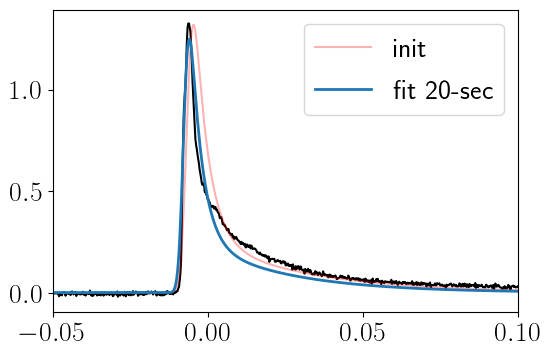

In [90]:
plt.plot(xfit,yfit,color='black')
plt.plot(xfit, flare_model(xfit, *init_vals),color='red', label='init', alpha=0.3)
plt.plot(xfit, flare_model(xfit, *popt),color='C0', label='fit 20-sec', lw=2)
plt.legend()
plt.xlim(-0.05,0.1)

In [91]:
print(popt)
print(pcov)

[-0.00628625  0.00605073  1.3064281 ]
[[ 3.27800916e-10  2.58051325e-10 -2.78567346e-08]
 [ 2.58051325e-10  3.14150759e-09 -3.39126921e-07]
 [-2.78567346e-08 -3.39126921e-07  7.10815647e-05]]


Fitting Jim's 2014 Model

In [92]:
#bounds=((xmin,2e-02,6e-01),(xmax,1,1.5))

#init_vals2= [2.45916793e+06, 3.01631592e-02, 6.01085052e-01]
#init_vals2 =[2.45916780e+06, .7e-02, 1.35]

init_vals2 =[-0.005, .7e-02, 1.38] #Jim's vals
j_popt, j_pcov = curve_fit(aflare1, xfit,yfit, p0=init_vals2,maxfev=100000)#,bounds=bounds)
print(j_popt)
print(j_pcov)

[-0.00616781  0.00601594  1.38069202]
[[ 2.42664849e-10  2.11321061e-10 -2.24170011e-08]
 [ 2.11321061e-10  3.12907124e-09 -3.57689454e-07]
 [-2.24170011e-08 -3.57689454e-07  7.35034900e-05]]


Text(0.5, 1.0, '20 Second TESS Data')

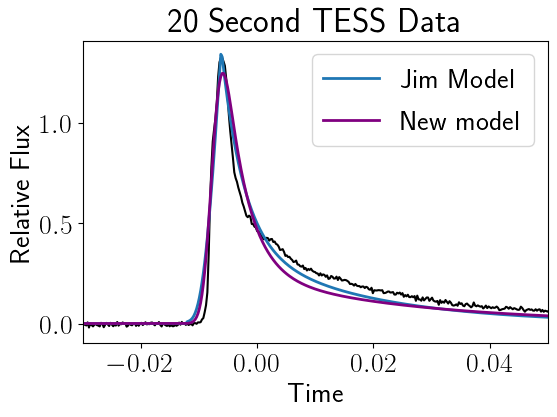

In [99]:
plt.plot(xfit,yfit,color='black')
#plt.plot(xfit, aflare1(xfit, *init_vals2),color='red', label='init', alpha=0.3)
plt.plot(xfit, aflare1(xfit, *j_popt),color='C0', label='Jim Model', lw=2)
plt.plot(xfit, flare_model(xfit, *popt),color='purple', label='New model', lw=2)
plt.legend()
plt.xlim(-0.03,0.05)
plt.xlabel('Time')
plt.ylabel('Relative Flux')
plt.title('20 Second TESS Data')

Note: Given the structure of this flare in the 20s data this may be a complex flare and would explain why our models aren't fitting the data as well as they normally would

### If the 20s data were sampled at 2min what would the fit look like?


In [101]:
xmin = 67.6+2.4591e6
xmax = 68.2+2.4591e6
mask2 = ~(np.isnan(lc2.time.jd) | np.isnan(lc2median))
x_mask2 = np.where((lc2.time.jd[mask2] > xmin) & (lc2.time.jd[mask2] < xmax))[0]
print(len(x_mask2))
print(len(lc2.time.jd))

432
17305


In [103]:
xfit_2min = lc2.time.jd[mask2][x_mask2] - 2.45916781e+06 # approx t_peak
yfit_2min = lc2median[mask2][x_mask2]

In [104]:
p0 =[-0.005, .7e-02, 1.38] #Jim's vals
#init_vals=[2.45916779e+06, 7.00000000e-03, 1.39000000e+00]
popt2, pcov2 = curve_fit(flare_model, xfit_2min,yfit_2min, p0=p0,maxfev=100000)
print(popt2)
print(pcov2)

[-0.00625875  0.00625167  1.2834255 ]
[[ 1.92990476e-09  1.51994553e-09 -1.56007232e-07]
 [ 1.51994553e-09  1.85190592e-08 -1.90089863e-06]
 [-1.56007232e-07 -1.90089863e-06  3.78634534e-04]]


Text(0.5, 1.0, '2min TESS Data')

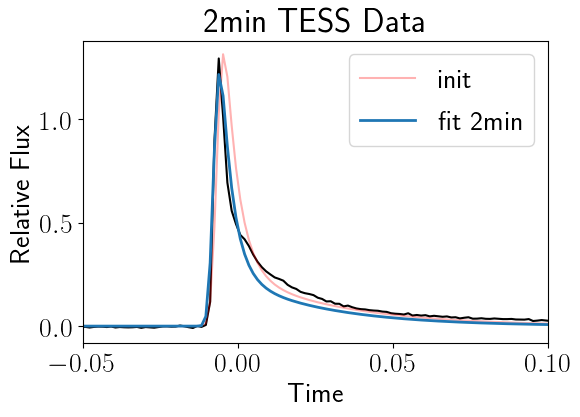

In [106]:
plt.plot(xfit_2min,yfit_2min,color='black')
plt.plot(xfit_2min, flare_model(xfit_2min, *init_vals),color='red', label='init', alpha=0.3)
plt.plot(xfit_2min, flare_model(xfit_2min, *popt2),color='C0', label='fit 2min', lw=2)
plt.legend()
plt.xlim(-0.05,0.1)
plt.xlabel('Time')
plt.ylabel('Relative Flux')
plt.title('2min TESS Data')

Fitting 2min data w/Jim's model

In [107]:
init_vals2min =[-0.005, .7e-02, 1.38] #Jim's vals
j2_popt, j2_pcov = curve_fit(aflare1, xfit_2min,yfit_2min, p0=init_vals2min,maxfev=100000)#,bounds=bounds)
print(j2_popt)
print(j2_pcov)

[-0.00609218  0.0064999   1.30736947]
[[ 1.42195171e-09 -1.34372129e-10  1.36413238e-07]
 [-1.34372129e-10  1.75803564e-08 -1.68369230e-06]
 [ 1.36413238e-07 -1.68369230e-06  3.30788103e-04]]


Text(0.5, 1.0, '2 min TESS Data')

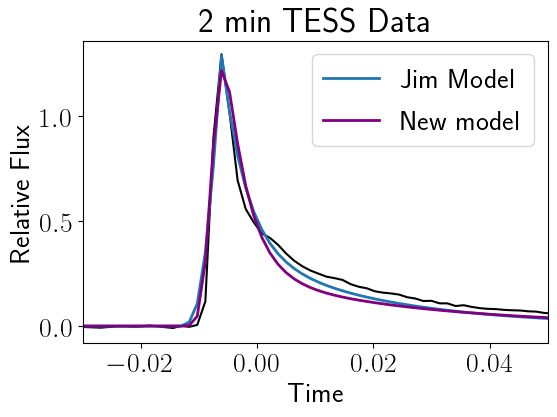

In [109]:
plt.plot(xfit_2min,yfit_2min,color='black')
#plt.plot(xfit_2min, flare_model(xfit_2min, *init_vals),color='red', label='init', alpha=0.3)
plt.plot(xfit_2min, aflare1(xfit_2min, *j2_popt),color='C0', label='Jim Model', lw=2)
plt.plot(xfit_2min, flare_model(xfit_2min, *popt2),color='purple', label='New model', lw=2)
plt.legend()
plt.xlim(-0.03,0.05)
plt.xlabel('Time')
plt.ylabel('Relative Flux')
plt.title('2 min TESS Data')

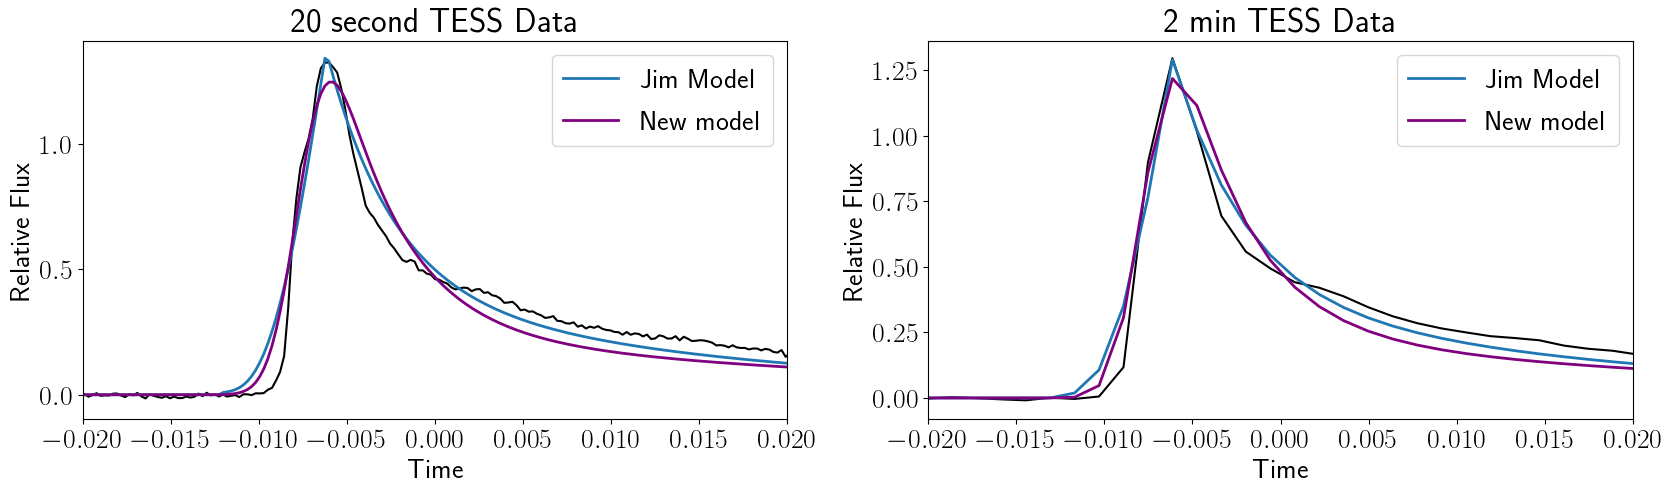

In [118]:
fig, axs = plt.subplots(1,2, figsize=(20, 5), facecolor='w', edgecolor='k')
axs[0].plot(xfit,yfit,color='black')
#plt.plot(xfit, aflare1(xfit, *init_vals2),color='red', label='init', alpha=0.3)
axs[0].plot(xfit, aflare1(xfit, *j_popt),color='C0', label='Jim Model', lw=2)
axs[0].plot(xfit, flare_model(xfit, *popt),color='purple', label='New model', lw=2)
axs[0].legend()
axs[0].set_xlim(-0.02,0.02)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Relative Flux')
axs[0].set_title('20 second TESS Data')


axs[1].plot(xfit_2min,yfit_2min,color='black')
#plt.plot(xfit_2min, flare_model(xfit_2min, *init_vals),color='red', label='init', alpha=0.3)
axs[1].plot(xfit_2min, aflare1(xfit_2min, *j2_popt),color='C0', label='Jim Model', lw=2)
axs[1].plot(xfit_2min, flare_model(xfit_2min, *popt2),color='purple', label='New model', lw=2)
axs[1].legend()
axs[1].set_xlim(-0.02,0.02)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Relative Flux')
axs[1].set_title('2 min TESS Data')
#plt.savefig('/Users/lupitatovar/local_flares/figures/tess_exs_cmplx_fit.pdf')

Since the flare above is likely to be a complex event we choose another flare to model

(2459160.87, 2459160.95)

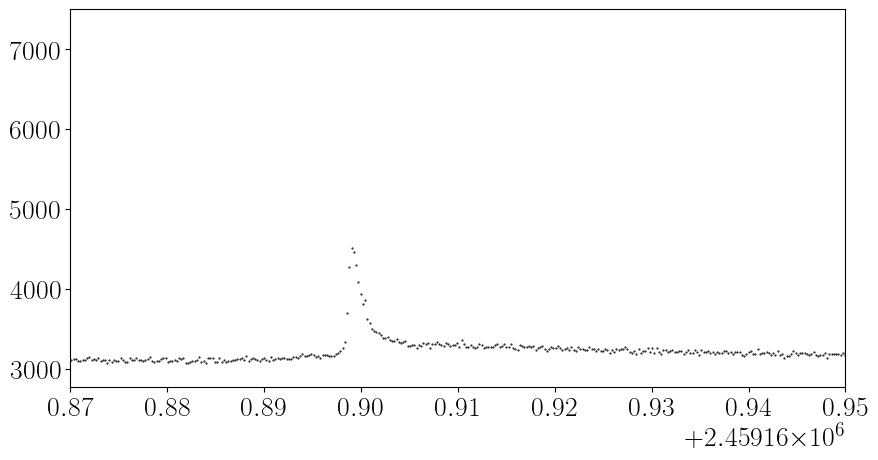

In [123]:
plt.figure(figsize=(10,5))
plt.plot(lc1.time.jd, lc1['sap_flux'], 'k.', markersize=1)
#plt.xlim(60.8+2.4591e6,61+2.4591e6)
plt.xlim(60.87+2.4591e6,60.95+2.4591e6)

(-0.03, 0.5)

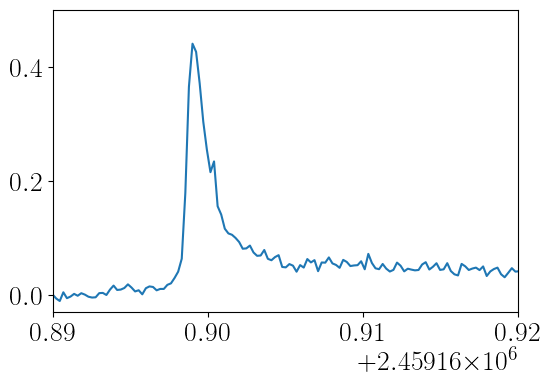

In [146]:
plt.plot(lc1.time.jd,lc1median)
#plt.scatter(60.899+2.4591e6,0.45,color='red',s=10)
plt.xlim(60.89+2.4591e6,60.92+2.4591e6)
plt.ylim(-0.03,0.5)

In [145]:
60.899+2.4591e6

2459160.899

In [135]:
xmin2 = 2459160.89
xmax2 = 2459160.92
#mask2 = ~(np.isnan(lc2.time.jd) | np.isnan(lc2median))
x_mask_f2 = np.where((lc1.time.jd[mask] > xmin2) & (lc1.time.jd[mask] < xmax2))[0]
print(len(x_mask2))
#print(len(lc2.time.jd))

432


In [328]:
f2xfit = lc1.time.jd[mask][x_mask_f2] - 2459160 # approx t_peak
f2yfit = lc1median[mask][x_mask_f2]

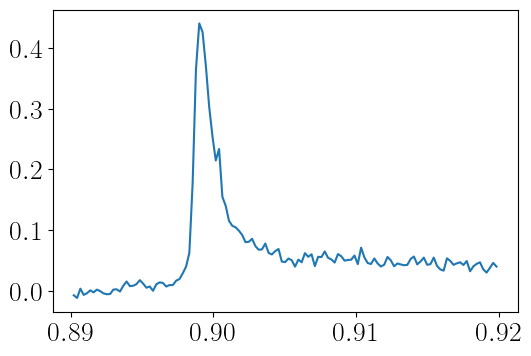

In [329]:
plt.plot(f2xfit,f2yfit)

In [468]:
f2 =[0.89901, 0.003, 0.46] 
#f2=[0.899, 0.003, 0.465]
f2popt, f2pcov = curve_fit(flare_model, f2xfit,f2yfit, p0=f2,maxfev=1000000)
print(f2popt)
print(f2pcov)

[0.89906826 0.00178858 0.44016839]
[[ 6.60130505e-10  5.33499685e-10 -6.53094589e-08]
 [ 5.33499685e-10  6.47903705e-09 -7.93523913e-07]
 [-6.53094589e-08 -7.93523913e-07  1.87283337e-04]]


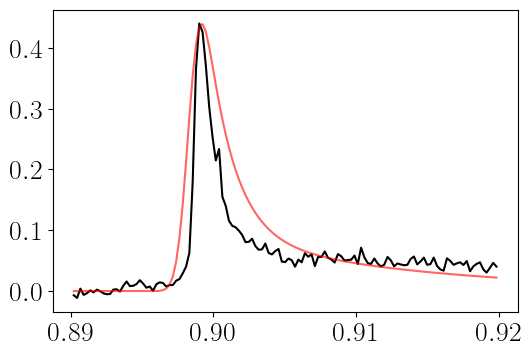

In [469]:
plt.plot(f2xfit,f2yfit,color='black')
plt.plot(f2xfit, flare_model(f2xfit, *f2),color='red', label='init', alpha=0.6)
#plt.xlim(0.895,0.91)

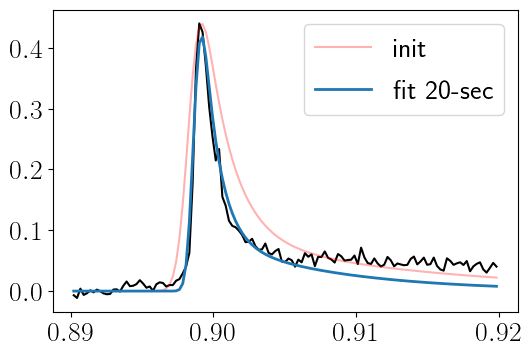

In [470]:
plt.plot(f2xfit,f2yfit,color='black')
plt.plot(f2xfit, flare_model(f2xfit, *f2),color='red', label='init', alpha=0.3)
plt.plot(f2xfit, flare_model(f2xfit, *f2popt),color='C0', label='fit 20-sec', lw=2)
plt.legend()
#plt.xlim(-0.05,0.1)

2min data

In [476]:
f2_mask = np.where((lc2.time.jd[mask2] > xmin2) & (lc2.time.jd[mask2] < xmax2))[0]
f2xfit_2min = lc2.time.jd[mask2][f2_mask] - 2459160 # approx t_peak
f2yfit_2min = lc2median[mask2][f2_mask]

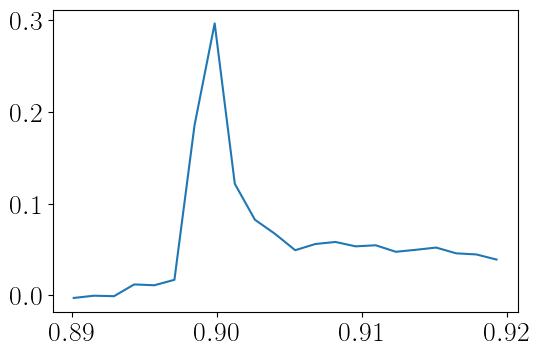

In [477]:
plt.plot(f2xfit_2min,f2yfit_2min)

In [544]:
f2min =[0.89901, 0.002, 0.4] 
#f2=[0.899, 0.003, 0.465]
best_vals, cov = curve_fit(flare_model, f2xfit_2min,f2yfit_2min, p0=f2min,maxfev=1000000)
print(best_vals)
print(cov)

[0.89912879 0.00270717 0.33719428]
[[ 7.17967630e-09  2.01661381e-08 -1.45804930e-06]
 [ 2.01661381e-08  2.07709988e-07 -1.55122139e-05]
 [-1.45804930e-06 -1.55122139e-05  1.45635166e-03]]


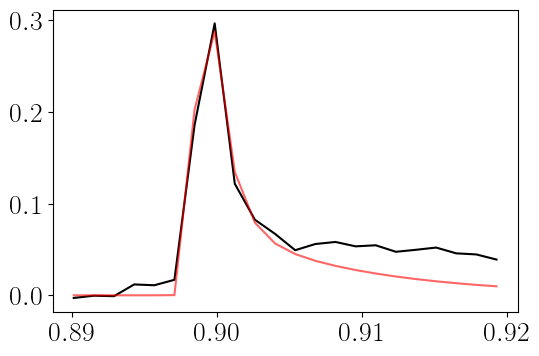

In [545]:
plt.plot(f2xfit_2min,f2yfit_2min,color='black')
plt.plot(f2xfit_2min, flare_model(f2xfit_2min, *f2min),color='red', label='init', alpha=0.6)
#plt.xlim(0.895,0.91)

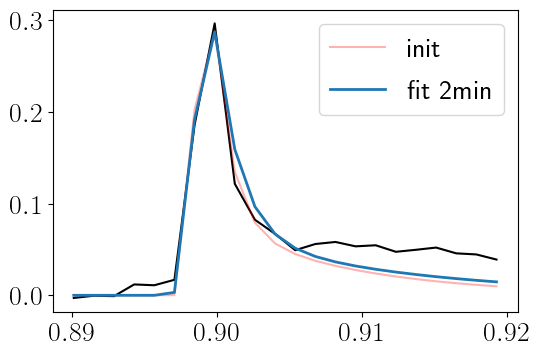

In [543]:
plt.plot(f2xfit_2min,f2yfit_2min,color='black')
plt.plot(f2xfit_2min, flare_model(f2xfit_2min, *f2min),color='red', label='init', alpha=0.3)
plt.plot(f2xfit_2min, flare_model(f2xfit_2min, *best_vals),color='C0', label='fit 2min', lw=2)
plt.legend()

Comparing 2min v 20sec data

Text(0.5, 1.0, '2 min TESS Data')

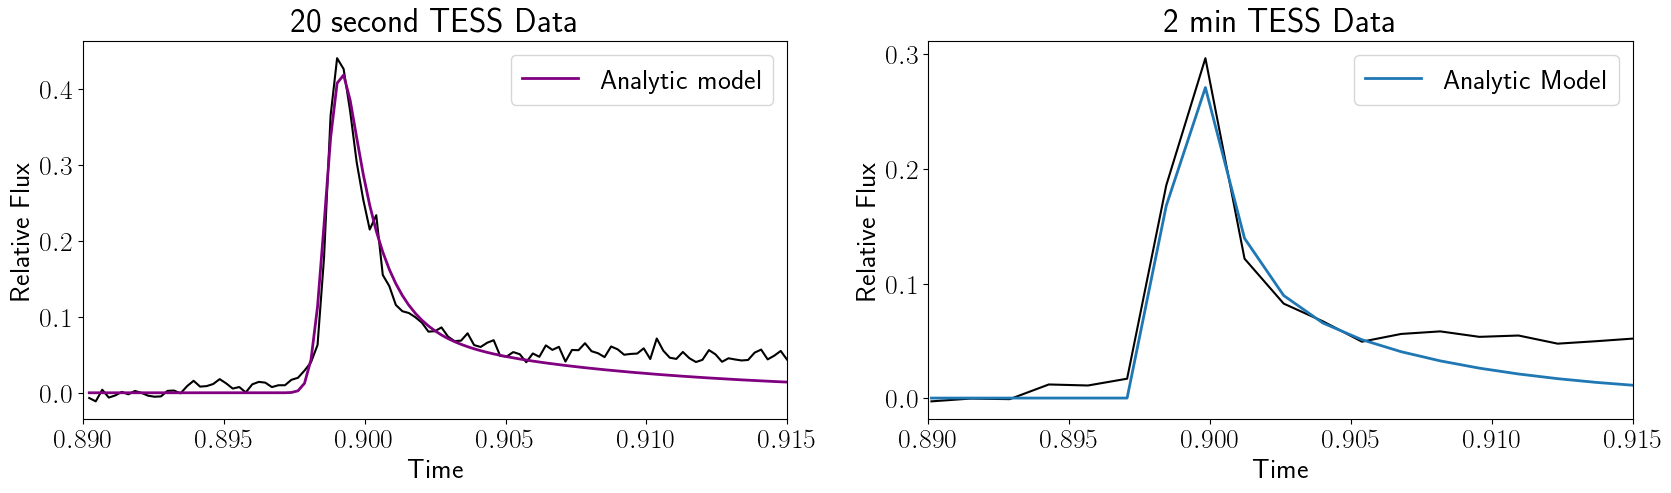

In [521]:
fig, axs = plt.subplots(1,2, figsize=(20, 5), facecolor='w', edgecolor='k')
axs[0].plot(f2xfit,f2yfit,color='black')
#plt.plot(xfit, aflare1(xfit, *init_vals2),color='red', label='init', alpha=0.3)
#axs[0].plot(xfit, aflare1(xfit, *j_popt),color='C0', label='Jim Model', lw=2)
axs[0].plot(f2xfit, flare_model(f2xfit, *f2popt),color='purple', label='Analytic model', lw=2)
axs[0].legend()
axs[0].set_xlim(0.89,0.915)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Relative Flux')
axs[0].set_title('20 second TESS Data')


axs[1].plot(f2xfit_2min,f2yfit_2min,color='black')
#plt.plot(xfit_2min, flare_model(xfit_2min, *init_vals),color='red', label='init', alpha=0.3)
axs[1].plot(f2xfit_2min, aflare1(f2xfit_2min, *best_vals),color='C0', label='Analytic Model', lw=2)
#axs[1].plot(f2xfit_2min, flare_model(f2xfit_2min, *popt2),color='purple', label='New model', lw=2)
axs[1].legend()
axs[1].set_xlim(0.89,0.915)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Relative Flux')
axs[1].set_title('2 min TESS Data')
#plt.savefig('/Users/lupitatovar/local_flares/figures/tess_exs_cmplx_fit.pdf')